In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)

In [28]:
df_train_ori = pd.read_csv('./Admission_Predict.csv')
# Dropping a few columns.  Waterfront and view are binary. 
df_train_ori = df_train_ori.drop(['Serial No.'],axis=1)

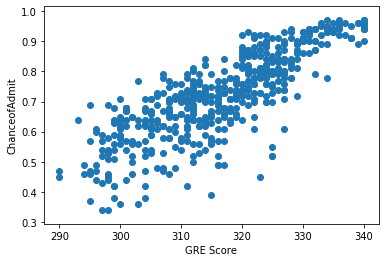

In [29]:
#In this project, as we are predicting the SalePrice of a property, it is a common sense that there should be a linear relationsip
#between the area of the property and the sale price of the property. (The area of the property is in cloumn 'GrLivArea')

#We will use scatter plot to see if the relationship is linear. 
plt.scatter(x = df_train_ori['GRE Score'], y = df_train_ori['ChanceofAdmit'])
plt.ylabel('ChanceofAdmit')
plt.xlabel('GRE Score')
plt.show()

In [30]:
df_train_drop = df_train_ori.drop('ChanceofAdmit',1)
X = df_train_drop.values
y = df_train_ori.ChanceofAdmit.values
colnames = df_train_drop.columns

FINISH   :  0.00029999999999817185 [0.00180468 0.00245547 0.00460214 0.00023143 0.01382514 0.12017499
 0.01675766]


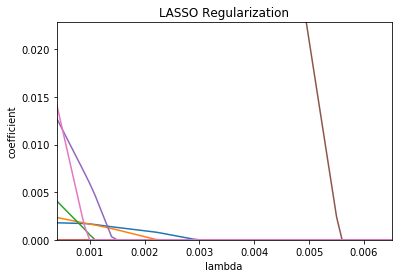

In [51]:
lassoCoefArr = np.ndarray(shape=(df_train_drop.shape[1],9000), dtype=float)
lambdaArr = np.array([])


lambdaIter = 0.1
firstNonZeroIndex = 0
lastIndex=0

while(lambdaIter<=1):
#     print(lambdaIter)
    # create a lasso regressor
    lasso = Lasso(alpha=lambdaIter, normalize=True)

    # Fit the regressor to the data
    lasso.fit(X,y)
    b = np.array([lambdaIter])
    c = np.array(lasso.coef_)
    lambdaArr = np.concatenate((lambdaArr, b), axis=0)
    
    
    for i in range(df_train_drop.shape[1]):
        lassoCoefArr[i][lastIndex]=lasso.coef_[i]
    
    numberOfNonZeroCoef=0
    for j in lasso.coef_:
        if j>0:
            numberOfNonZeroCoef += 1
    if numberOfNonZeroCoef==7:
        print("FINISH   : ",lambdaIter, lasso.coef_)
        break
        
    lambdaIter -= 0.0001
    round(lambdaIter,5)
    if numberOfNonZeroCoef==0:
        firstNonZeroIndex += 1
    lastIndex +=1


firstNonZeroIndex -= 10
plt.title('LASSO Regularization')
plt.xlabel('lambda')
plt.ylabel('coefficient')
colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','b', 'g', 'r', 'c', 'm', 'y', 'k']
for x in range(df_train_drop.shape[1]):
    plt.plot(lambdaArr[firstNonZeroIndex:lastIndex],lassoCoefArr[x][firstNonZeroIndex:lastIndex],colors[x])
plt.margins(0.00001)
plt.ylim(0,np.mean(lasso.coef_))
plt.show()


In [ ]:
lasso = Lasso(alpha=0.001, normalize=True)

# Fit the regressor to the data
lasso.fit(X,y)

# Plot the coefficients

plt.plot(range(len(colnames)), lasso.coef_)
plt.xticks(range(len(colnames)), colnames.values, rotation=60) 
plt.margins(0.0001)
plt.show()

In [ ]:
# Import the necessary module
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

# find the mean of our cv scores here
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

In [ ]:
from sklearn.linear_model import Ridge

# Create an array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Use this function to create a plot    
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [ ]:
arr = np.array([])
print(arr.dtype)
arrfirst = np.array([])
arrsecond= np.array([])
arrthird = np.array([])
arrfourth = np.array([])
arrfifth = np.array([])
arrsixth = np.array([])
arrseventh = np.array([])
alpha_value_loop = 0.1
index = 0

while(alpha_value_loop<=1):
#     print(alpha_value_loop)
    # create a lasso regressor
    lasso = Lasso(alpha=alpha_value_loop, normalize=True)

    # Fit the regressor to the data
    lasso.fit(X,y)
    b = np.array([alpha_value_loop])
    c = np.array(lasso.coef_)
    arr = np.concatenate((arr, b), axis=0)
    
    print(arrfirst.shape, np.array([lasso.coef_[0]]))
    arrfirst = np.concatenate((arrfirst, np.array([lasso.coef_[0]])),axis=0)
    arrsecond = np.concatenate((arrsecond, np.array([lasso.coef_[1]])),axis=0)
    arrthird = np.concatenate((arrthird, np.array([lasso.coef_[2]])),axis=0)
    arrfourth = np.concatenate((arrfourth, np.array([lasso.coef_[3]])),axis=0)
    arrfifth = np.concatenate((arrfifth, np.array([lasso.coef_[4]])),axis=0)
    arrsixth = np.concatenate((arrsixth, np.array([lasso.coef_[5]])),axis=0)
    arrseventh = np.concatenate((arrseventh, np.array([lasso.coef_[6]])),axis=0)
    
    
    temp=0
    for j in lasso.coef_:
        if j>0:
            temp += 1
    if temp==7:
        print("FINISH   : ",alpha_value_loop, lasso.coef_)
        break
        
    alpha_value_loop -= 0.0001
    round(alpha_value_loop,5)
    if temp==0:
        index += 1


index -= 10
plt.title('LASSO Regularization')
plt.xlabel('lambda')
plt.ylabel('coefficient')
plt.plot(arr[index:], arrfirst[index:], 'r', arr[index:], arrsecond[index:], 'b', arr[index:], arrthird[index:], 'g', arr[index:], arrfourth[index:], 'c', arr[index:], arrfifth[index:], 'k', arr[index:], arrsixth[index:], 'm',arr[index:], arrseventh[index:], 'y')
plt.margins(0.00001)
plt.ylim(0,np.mean(lasso.coef_))
plt.show()
